In [1]:
using MyBioTools.FluTools
using Dates
using Plots
using StatsBase, Statistics
using TreeTools
using Profile, ProfileView
using BenchmarkTools
# using BioTools, BioSequences
using Random
using EarthMoversDistance
include("functions/Predictions.jl")

┌ Info: Recompiling stale cache file /home/pierrebc/.julia/compiled/v1.1/MyBioTools.ji for MyBioTools [top-level]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/pierrebc/.julia/compiled/v1.1/EarthMoversDistance.ji for EarthMoversDistance [top-level]
└ @ Base loading.jl:1184


cluster_lbi_maxima! (generic function with 1 method)

In [2]:
pyplot()
plot(rand(10),size=(1,1))

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1186


In [3]:
sp = FluTools.StrainPop("../data/aligned_h3n2_ha_aa.fasta");

In [4]:
FluTools.remove_gapped_strains!(sp);

Removing strains...


I will work with bins of a few months (4 for instance). One of the later bins will be the target population, *i.e.* the one we will try to predict.  

First, let's look at the distance of past populations to the target population. 

In [5]:
FluTools.bin_by_date!(sp, start = Date(2002,12,1), binwidth=Day(61), binspacing = Day(122));
datebins = sort(collect(keys(sp.datebin)));

## Computing LBI
For each date bin, the LBI is recomputed. I attach to the fitness of each strain the LBI value it obtained for the date bin it is in.   

In [6]:
t = read_tree("../data/trees/tree_ha_100permonth_NEW/tree_raw.nwk", NodeDataType=LBIData);
FluTools.get_lbi!(sp, t);
for (d,v) in sp.lbi_datebin
    for s in values(sp.datebin[d])
        sp.straindict[s.strain].fitness = v[s.strain]
    end
end

  2.777607 seconds (9.79 M allocations: 1.169 GiB, 34.34% gc time)


## This should be averaged over many target populations.  
Also, it's not so useful to go very far back in the past. Let's go 5 years, that is 20 bins 

In [7]:
dat  = Dict()
datmin = Dict(); datcons = Dict(); dattoplbi = Dict(); ntoplbi = Dict()
start = 20
usedbins = datebins[start+1:end-12] # Removing the end ones for time reasons (lots of sequences in those)
for (i,db) in enumerate(usedbins)
    print("i = $i/$(length(usedbins))             \r")
    flush(stdout)
    local i += start
    target = sp.datebin[db]
    for (j,db2) in enumerate(datebins[i-12:i])
        
        pop = sp.datebin[db2]
        toplbi = pop[findmax([x.fitness for x in pop])[2]]
        avdist = FluTools.popdistance(target, pop)
        mindist = FluTools.popdistance(target, pop, disttype=:hamming_tophit)
        consdist = FluTools.popdistance(target, pop, disttype=:hamming_consensus)
        toplbidist = FluTools.popdistance(target, toplbi, disttype=:meanhamming)
        datediff = FluTools.datebin_to_date(db2) - FluTools.datebin_to_date(db)
        dat[datediff] = get(dat, datediff, 0.) + avdist / length(usedbins)
        datmin[datediff] = get(datmin, datediff, 0.) + mindist / length(usedbins)
        datcons[datediff] = get(datcons, datediff, 0.) + consdist / length(usedbins)
        if toplbi.fitness > -1
            dattoplbi[datediff] = get(dattoplbi, datediff, 0.) + toplbidist 
            ntoplbi[datediff] = get(ntoplbi, datediff, 0) + 1
        end
        if j == 1
#             println("Datebin = $db2")
#             println("Top lbi strain : $(toplbi.strain) -- $(toplbi.date) -- hamming $(toplbidist)")
#             println("Min hamming dist : $mindist")
#             println()
        end
    end
end
dattoplbi = Dict(k=>x/ntoplbi[k] for (k,x) in dattoplbi);

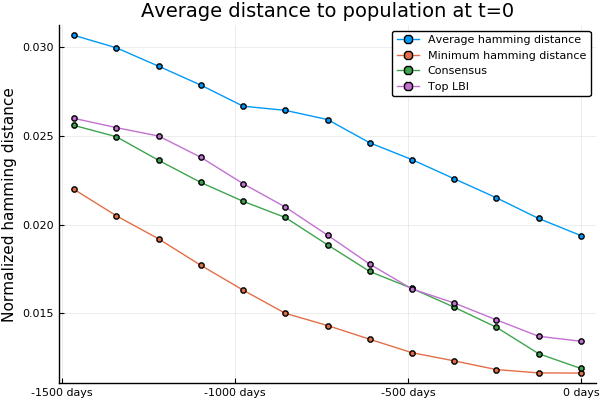

In [8]:
ts = [x[1] for x in sort(collect(dat), by=x->x[1])]
avh = [x[2] for x in sort(collect(dat), by=x->x[1])]
minh = [x[2] for x in sort(collect(datmin), by=x->x[1])]
consh = [x[2] for x in sort(collect(datcons), by = x->x[1])]
toplbih = [x[2] for x in sort(collect(dattoplbi), by = x->x[1])]
plot(ts,avh, label="Average hamming distance", marker=:o)
plot!(ts, minh, label="Minimum hamming distance", marker=:o)
plot!(ts, consh, label="Consensus", marker=:o)
plot!(ts, toplbih, label="Top LBI", marker=:o)
plot!(ylabel="Normalized hamming distance", title="Average distance to population at t=0")

So the consensus is better than the LBI. Thinking of it, picking the consensus amounts to picking the root of the biggest current clade: smaller clades are probably ignored!  
Since we think the LBI does something similar, how close is the top lbi strain to the consensus, compared to typical variability in the pop?

In [43]:
db = datebins[25]
println(db)
db2 = datebins[29]
cons1 = FluTools.consensus(sp.datebin[db])
FluTools.popdistance(sp.datebin[db2], cons1)

(2010-12-07, 2011-04-08)


16.933553856487265

In [101]:
dat = Dict()
for db in datebins[25:end]
    pop = sp.datebin[db]
    toplbi = pop[findmax([x.fitness for x in pop])[2]]
    consensus = FluTools.consensus(pop)
    dat[db] = (poptocons=FluTools.popdistance(pop,consensus, disttype=:meanhamming), lbitocons=FluTools.hamming(toplbi.aa_seq, consensus.aa_seq, normalize=true))
end
dat = sort(dat);

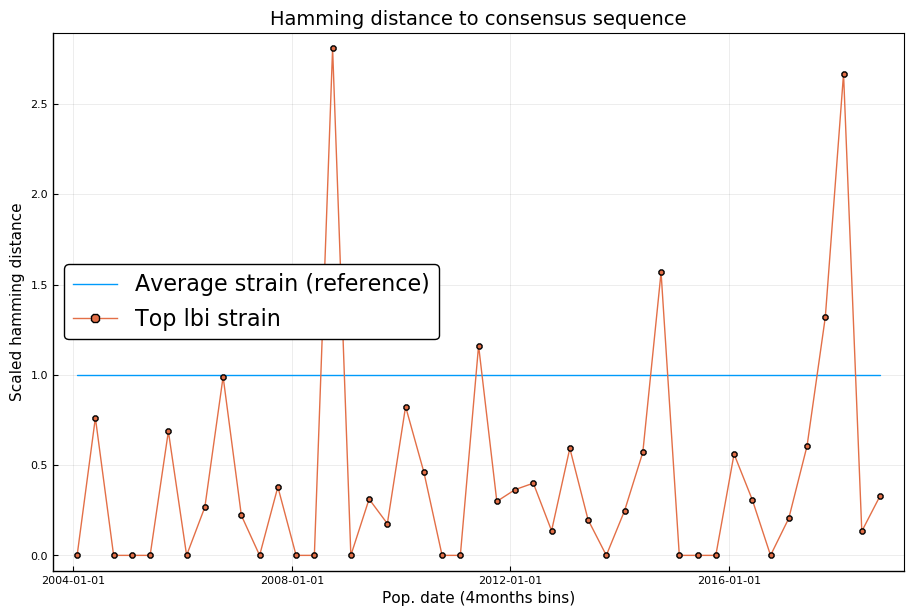

In [102]:
plot([FluTools.datebin_to_date(x) for x in keys(dat)], ones(length(values(dat))), label="Average strain (reference)")
plot!([FluTools.datebin_to_date(x) for x in keys(dat)], [x.lbitocons for x in values(dat)]./[x.poptocons for x in values(dat)], label="Top lbi strain", marker=:o)
plot!(xlabel="Pop. date (4months bins)", ylabel="Scaled hamming distance", title="Hamming distance to consensus sequence", legendfontsize=16, size=(900,600), box=true)
savefig("tempplots_predictions/hammingdistance_to_consensus_vs_date.png")

Let's see if changing the integration timescale for LBI gets us closer to the consensus

In [103]:
y = []
ctvalues = [1,10,50,100,200,500,1000,5000,10000];
for ct in ctvalues # Integration time in days for LBI
    println("Integration time: $ct days")
    # Computing LBI for strains
    println("Reading tree...")
    t = read_tree("../data/trees/tree_ha_100permonth_NEW/tree_raw.nwk", NodeDataType=LBIData);
    println("Computing LBI...")
    FluTools.get_lbi!(sp, t, τ = FluTools.substitution_rate["h3n2","ha"] * ct / 365);
    for (d,v) in sp.lbi_datebin
        for s in values(sp.datebin[d])
            sp.straindict[s.strain].fitness = v[s.strain]
        end
    end
    # Getting the top LBI for each timebin
    println("Computing hamming distances...")
    dat = Dict()
    for db in datebins[30:end]
        pop = sp.datebin[db]
        toplbi = pop[findmax([x.fitness for x in pop])[2]]
        consensus = FluTools.consensus(pop)
        dat[db] = (poptocons=FluTools.popdistance(pop,consensus, disttype=:meanhamming), lbitocons=FluTools.hamming(toplbi.aa_seq, consensus.aa_seq, normalize=true))
    end
    dat = sort(dat);
    # Showing results
#     plot!(p, [FluTools.datebin_to_date(x) for x in keys(dat)], [x.lbitocons for x in values(dat)]./[x.poptocons for x in values(dat)], label="Top LBI - T=$ct days", marker=:o)
    push!(y, mean([x.lbitocons for x in values(dat)]./[x.poptocons for x in values(dat)]))
    println()
end

Integration time: 1 days
Reading tree...
  4.464189 seconds (9.01 M allocations: 1.132 GiB, 53.04% gc time)
Computing LBI...


┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

Computing hamming distances...

Integration time: 10 days
Reading tree...
  3.469709 seconds (9.01 M allocations: 1.132 GiB, 49.40% gc time)
Computing LBI...


┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

Computing hamming distances...

Integration time: 50 days
Reading tree...
  3.808275 seconds (9.01 M allocations: 1.132 GiB, 55.88% gc time)
Computing LBI...


┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

Computing hamming distances...

Integration time: 100 days
Reading tree...
  3.373153 seconds (9.01 M allocations: 1.132 GiB, 49.52% gc time)
Computing LBI...


┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

Computing hamming distances...

Integration time: 200 days
Reading tree...
  3.892630 seconds (9.01 M allocations: 1.132 GiB, 54.48% gc time)
Computing LBI...


┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

Computing hamming distances...

Integration time: 500 days
Reading tree...
  3.497558 seconds (9.01 M allocations: 1.132 GiB, 49.61% gc time)
Computing LBI...


┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

Computing hamming distances...

Integration time: 1000 days
Reading tree...
  3.848984 seconds (9.01 M allocations: 1.132 GiB, 54.90% gc time)
Computing LBI...


┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

Computing hamming distances...

Integration time: 5000 days
Reading tree...
  3.951751 seconds (9.01 M allocations: 1.132 GiB, 55.00% gc time)
Computing LBI...


┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

Computing hamming distances...

Integration time: 10000 days
Reading tree...
  3.481996 seconds (9.01 M allocations: 1.132 GiB, 49.68% gc time)
Computing LBI...


┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

Computing hamming distances...



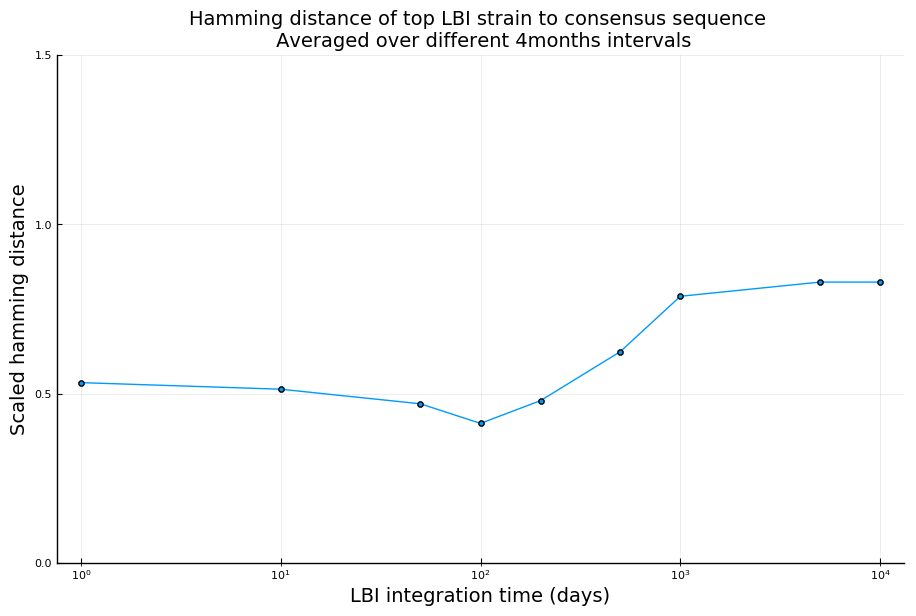

In [104]:
plot(ctvalues, y,  marker=:o, xscale=:log10, label="")
plot!(ylim=(0,1.5), ylabel="Scaled hamming distance", xlabel="LBI integration time (days)", size=(900,600))
plot!(guidefontsize=14, title="Hamming distance of top LBI strain to consensus sequence \n Averaged over different 4months intervals")
savefig("tempplots_predictions/hammingdistance_to_consensus_vs_LBItime.png")

# With a date-stamped tree
If internal nodes have dates, we can easily group leaves of a given period into clades, by having the roots these clades be in the given time period (or more recent than an abitrarily chosen date, *e.g.* 2 months before the start of the time period).  
This will allow us to check if taking the set of the clade-wise consensuses is a good heuristic for minimizing the EMD. These consensuse would have to be weighted by clades size obviously. 
What can also be tried is to take the top lbi nodes! Weighting is a bit more tricky here. One could assume that the number of high lbi nodes in a clade will be proportional to the clade size. 

In [118]:
include("functions/Predictions.jl")

dates_to_tree! (generic function with 2 methods)

In [164]:
t = read_tree("../data/trees_for_augur/100_per_4month/results/tree_raw.nwk", NodeDataType=LBIData);
dates_to_tree!(t, "../data/trees_for_augur/100_per_4month/results/branch_lengths.json")

  0.295329 seconds (663.11 k allocations: 99.427 MiB, 20.93% gc time)


In [274]:
db = datebins[61]
strains = String[]
for s in [x.strain for x in sp.datebin[db]]
    if haskey(t.lleaves, s)
        push!(strains, s)
    end
end
clades = split_in_clades(t, strains, db[1]-Month(4));

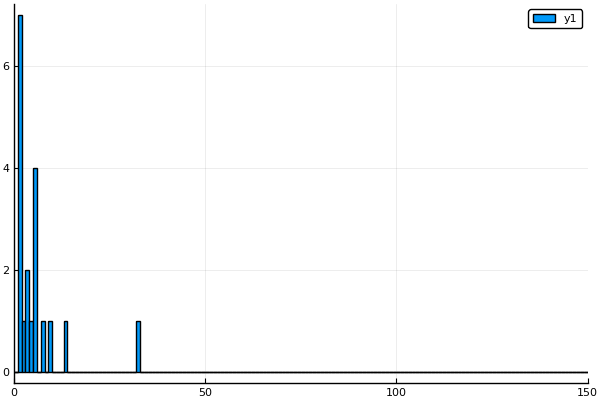

In [275]:
histogram([length(x) for x in values(clades)], bins = 0:1:300, xlim=(0,150))

In [276]:
db

(2015-12-05, 2016-04-05)

## Let's write these to a fasta
I'll select ~100 sequences for each 4 months bin starting in 2002. For all of these sequences, the metadata will include
- the distance to the consensus
- the lbi value based on the tree at this date  

For augur to work properly, I'll use the nt sequences

In [60]:
t = read_tree("../data/trees/tree_building_ha_100permonth/tree_raw.nwk", NodeDataType=LBIData);
FluTools.get_lbi!(sp, t);
for (d,v) in sp.lbi_datebin
    for s in values(sp.datebin[d])
        sp.straindict[s.strain].fitness = v[s.strain]
    end
end

  6.606828 seconds (9.30 M allocations: 1.182 GiB, 52.42% gc time)


┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warning: Cannot compute LBI for tree with dead leaves.
└ @ TreeTools /home/pierrebc/Documents/BaleLabo/Code/MyTools/TreeTools/src/lbi.jl:27
┌ Warn

In [66]:
strains_to_write = Array{BioTools.Strain}(undef, 0)
for db in datebins[20:end]
    pop = sp.datebin[db]
    n = 0; i = 1; strains = []
    while n < 100 && i <= length(pop)
        local s = pop[i]
        if haskey(t.lleaves, s.strain)
            push!(strains, s)
            n += 1
        end
#         println(i, "/", length(pop), " -- ", n, " -- ", s.strain)
        i += 1
    end
    cons = FluTools.consensus(pop)
    dist_to_cons_scale = maximum([FluTools.hamming(s.aa_seq, cons.aa_seq) for s in strains])
    
#     println([x.strain for x in strains])
    for s in strains
        dat = Dict()
        dat["strain"] = s.strain
        dat["virus"] = "flu"
        dat["date"] = s.date
        dat["lbi"] = round(s.fitness, digits=5)
        dat["dist_to_consensus"] = round(FluTools.hamming(s.aa_seq, cons.aa_seq),digits=5) #/ dist_to_cons_scale, digits=5)
#         dat["is_best_predictor"] = 
        push!(strains_to_write, BioTools.Strain(s.aa_seq, dat, :aa))
    end
end

In [67]:
# Reading nt strains
nt_strains = BioTools.readfastastrains("../data/aligned_h3n2_ha.fasta", :dna, BioTools.augur_all_header_fields, strainfilter = BioTools.gapfilter);

Reading ../data/aligned_h3n2_ha.fasta...
Read 46527 strains out of 61848. Filtered 15318. Could not read 3


In [69]:
labels = map(x->x.data["strain"], strains_to_write)
nt_strains_to_write = Array{Strain{BioSequences.DNAAlphabet{4}},1}(undef,0)
for st in nt_strains
    tmp = findfirst(==(st.data["strain"]), labels)
    if !isnothing(tmp) && st.data["country"]!="?"
        push!(nt_strains_to_write, Strain(st.seq, merge(strains_to_write[tmp].data, st.data)))
    end
end

In [70]:
fields = [:strain, :date, :virus, :lbi, :dist_to_consensus, :region, :country, :authors]
BioTools.writefasta("../data/trees_for_augur/100_per_4month/aligned_ha_nt.fasta", nt_strains_to_write, fields)
open("../data/trees_for_augur/100_per_4month/fieldnames.txt", "w") do io
    for (i,f) in enumerate(fields)
        write(io, "$f")
        if i < length(fields)
            write(io, " ")
        end
    end
end

In [71]:
lbivals = [x.data["lbi"] for x in nt_strains_to_write]
dconsvals = [x.data["dist_to_consensus"] for x in nt_strains_to_write];

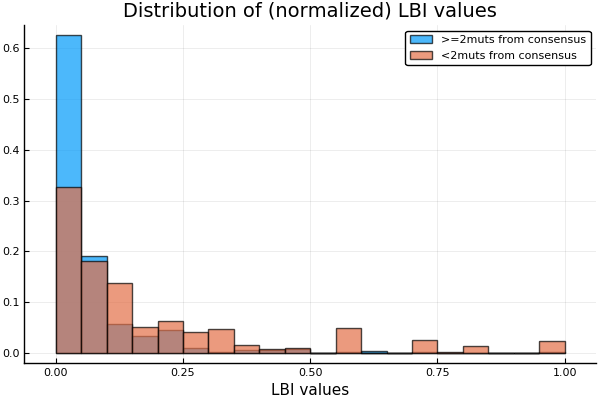

In [72]:
b = 0:0.05:1
histogram(lbivals[findall(x->x>=2, dconsvals)], bins=b, alpha=0.7, normalized=:probability, label=">=2muts from consensus")
histogram!(lbivals[findall(x->x<2, dconsvals)], bins = b, alpha=0.7, normalized=:probability, label="<2muts from consensus")
plot!(xlabel="LBI values", title="Distribution of (normalized) LBI values")

In [ ]:
A/Norway/2160/2013



In [180]:
using Clustering

In [258]:
dmat= zeros(Float64, length(strains), length(strains))
for (i,si) in enumerate(strains)
    for (j,sj) in enumerate(strains)
#         dmat[i,j] = node_divtime(t.lnodes[si], t.lnodes[sj])
        seq1 = LongAminoAcidSeq(sp.straindict[si].aa_seq)
        seq2 = LongAminoAcidSeq(sp.straindict[sj].aa_seq)
        dmat[i,j] = BioTools.hamming(seq1, seq2)
        dmat[j,i] = dmat[i,j]
    end
end

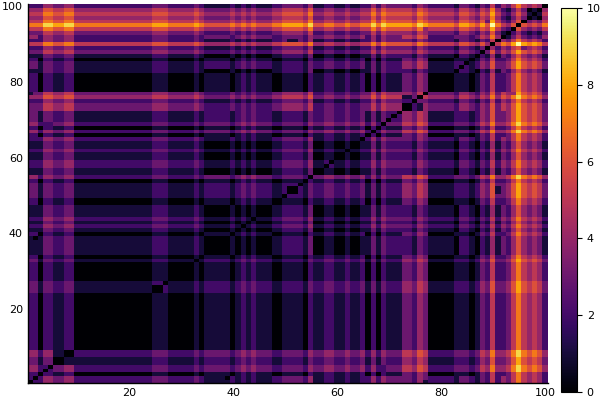

In [259]:
heatmap(dmat)

In [222]:
out = hclust(dmat)

Hclust{Float64}([-3 -10; -11 1; … ; -96 97; -89 98], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 4.0, 4.0, 10.0], [89, 96, 95, 90, 81, 69, 88, 94, 92, 93  …  38, 60, 61, 37, 63, 64, 36, 83, 35, 87], :single)

In [238]:
clusters = cutree(out, k=20);

In [247]:
findall(==("A/NoveZamky/897/2013"), strains)

1-element Array{Int64,1}:
 74

In [255]:
findall(==("A/Guangdong/114/2013"), strains)

1-element Array{Int64,1}:
 90

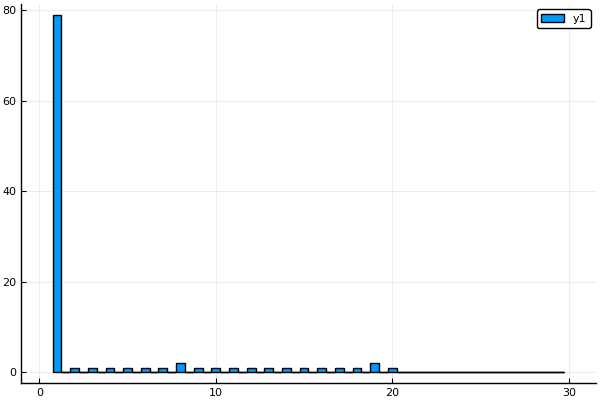

In [254]:
histogram(clusters, bins = 0.75:0.5:30)

In [240]:
db

(2012-12-02, 2013-04-03)

In [260]:
dmat[90,74]

6.0

In [252]:
clusters[73]

8

In [253]:
clusters[74]

8

In [262]:
LongAminoAcidSeq(sp.straindict["A/Guangdong/114/2013"].aa_seq)

566aa Amino Acid Sequence:
MKNIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNG…KDWILWISFAISCFLLCVVLLGFIMWACQKGNIRCNICI

In [264]:
LongAminoAcidSeq(sp.straindict["A/NoveZamky/897/2013"].aa_seq) .!= LongAminoAcidSeq(sp.straindict["A/Guangdong/114/2013"].aa_seq)

566-element BitArray{1}:
 false
 false
  true
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
     ⋮
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false
 false

In [265]:
LongAminoAcidSeq(sp.straindict["A/NoveZamky/897/2013"].aa_seq)

566aa Amino Acid Sequence:
MKTIIALSYILCLVFAQKLPGNDNSTATLCLGHHAVPNG…KDWILWISFAISCFLLCVALLGFIMWACQKGNIRCNICI